In [1]:
from __future__ import division

import sys

import numpy as np
import pandas as pd
import datetime
import time

# music api imports
import spotipy
import spotipy.util as util
import billboard
import pygn
import pylast

import requests
import re
from bs4 import BeautifulSoup
from time import sleep
import pickle
import cPickle as pk

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'text.color': 'white', 
         'xtick.color': 'white', 'ytick.color': 'white', 'axes.labelcolor': 'white', 'axes.edgecolor': 'white'})

In [2]:
from sklearn import cross_validation, datasets, linear_model, grid_search, metrics, ensemble, tree
from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

## Mood Mapping

In [3]:
mood_map = {'Peaceful': (-2,2), 'Easygoing': (-1,2), 'Tender': (-2,1), 'Romantic': (-1,1), 
        'Upbeat': (0,2), 'Empowering': (0,1),
        'Lively': (1,2), 'Excited': (2,2), 'Stirring': (1,1), 'Rowdy': (2,1),
        'Sentimental': (-2,0), 'Sophisticated': (-1,0),
        'Sensual': (0,0), 
        'Fiery': (1,0), 'Energizing': (2,0),
        'Melancholy': (-2,-1), 'Cool': (-1,-1), 'Somber': (-2,-2), 'Gritty': (-1,-2),
        'Yearning': (0,-1), 'Serious': (0,-2),
        'Urgent': (1,-1), 'Defiant': (2,-1), 'Brooding': (1,-2), 'Aggressive': (2,-2)}

In [4]:
reverse_mood_map = {v: k for k, v in mood_map.items()}

def get_reverse_mood_map(x): 
    return reverse_mood_map[x]
    
def get_mood_map(x):
    return mood_map[x]

# Load Pickle Points

In [5]:
with open('data/models.pkl', 'rb') as f:
    models = pk.load(f)

In [6]:
models

{'GBC': GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
               max_depth=3, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False),
 'RFC': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'XGB': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
        gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
        min_child_weight=1, missing=nan, n_estimators=300, nthread=-1,
        objective='multi:softpr

## Production Process

1. Get song features
  * for each song in a spotify playlist
  * get audio attributes
  * scale audio attributes
2. Predict song features
  * for song in spotify playlist
  * predict mood
3. Tally up moods
  * value counts 
4. Use count of moods to visualize in D3/Flask

In [6]:
master_songs_scaled = pd.read_pickle('data/master_songs_scaled.pkl')

In [7]:
master_songs_target = pd.read_pickle('data/master_songs_target.pkl')

In [10]:
master_songs_scaled.head()

,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence
0,0.542671,1.027451,-0.089725,0.634236,-0.479225,-0.918312,-0.034706,-0.338594,-0.293056,0.368074,1.334687
1,1.122133,0.985486,-0.116530,0.788555,-0.441018,-0.905551,-0.615815,-0.179941,-0.782808,0.895697,1.675768
2,-0.500362,1.205807,-0.431483,0.291516,-0.394452,-0.916943,1.145299,1.001753,-0.376475,0.542307,-1.248332
3,-0.616254,-1.196742,-0.458287,-0.093116,-0.363408,1.703642,-0.615815,0.006067,0.051520,0.160328,0.311444
4,-1.949018,-0.151091,-0.022714,-1.462477,-0.559223,-0.111196,-0.615815,-0.852850,0.484950,-0.164949,-0.761621


In [11]:
master_songs_target.head()

,mood_1,mood_map,mood_x,mood_y,simple_x,simple_y
0,Brooding,"(1, -2)",1,-2,1,-1
1,Aggressive,"(2, -2)",2,-2,1,-1
2,Energizing,"(2, 0)",2,0,1,0
4,Romantic,"(-1, 1)",-1,1,-1,1
5,Brooding,"(1, -2)",1,-2,1,-1


In [13]:
master_songs_3 = pd.read_pickle('data/master_songs_3.pkl')

In [17]:
master_df = pd.concat([master_songs_3, master_songs_target], axis=1)

In [18]:
master_df

,artist,explicit,id,popularity,title,energy,liveness,tempo,speechiness,acousticness,...,genre_3,gnid,mood_1,mood_2,mood_1,mood_map,mood_x,mood_y,simple_x,simple_y
0,Nirvana,False,3FUsMXBxA4V7eUwQ7B0HQO,48,Love Buzz,0.885000,0.1690,138.153,0.035400,0.000032,...,Grunge,5007273-06983AE0CA94A42592A86F999A523B41,Brooding,Alienated / Brooding,Brooding,"(1, -2)",1,-2,1,-1
1,The Presidents Of The United States Of America,False,2JdzB67NvIa90K4gEZPLeX,58,Lump,0.873000,0.1650,142.726,0.038600,0.004680,...,Alternative Pop,7176919-C893DAE82E18906A0C45F2D6651DF095,Aggressive,Aggressive Power,Aggressive,"(2, -2)",2,-2,1,-1
2,Stanton Warriors,False,0zXLMZUCYZCx8Bq4jCr174,30,So Sweet,0.936000,0.1180,127.997,0.042500,0.000531,...,Breakbeat,542968754-3A3DE9DCC8AACF9DE2F055187073DCA2,Energizing,Abstract Beat,Energizing,"(2, 0)",2,0,1,0
4,Robyn,False,01NJd6s7Kyn6NSsPp503sh,28,Be Mine! - Live At The Cherrytree House,0.249000,0.1140,116.599,0.045100,0.955000,...,Pop Electronica,176433014-A2FF98AC415031B8A67464F3DED3BC22,Romantic,Heartfelt Passion,Romantic,"(-1, 1)",-1,1,-1,1
5,Pearl Jam,False,6qgpO647NPBUvBkm56vV7d,5,Black,0.548000,0.1790,76.020,0.028700,0.294000,...,Grunge,17527306-1F01011247D0A98978073E66BF4D5597,Brooding,Evocative / Intriguing,Brooding,"(1, -2)",1,-2,1,-1
6,Sam Hunt,False,3wx2kQWPn9p5UppQbNhPAk,67,Leave The Night On,0.953000,0.3490,171.971,0.062400,0.099600,...,Contemporary Country,459278920-F9806BD4AFF4B5DC038D6D65E70C0B6C,Yearning,Sensitive / Exploring,Yearning,"(0, -1)",0,-1,0,-1
8,Kaya May,False,4eg3wsiTrPa7KpwVai2VY7,56,"Hands to Myself, Love Yourself, Perfect (Acous...",0.445000,0.1130,110.056,0.050000,0.057500,...,Pop Vocal,604743990-4B9A5237E117F5CE9E8506362D53C1D9,Brooding,Dreamy Brooding,Brooding,"(1, -2)",1,-2,1,-1
9,Notaker,False,341ShRaeysVdxLetlI391K,56,Infinite,0.669000,0.1080,99.987,0.048300,0.093700,...,Club Dance,625141650-9A245193045FB288D1785D87C9D94308,Excited,Euphoric Energy,Excited,"(2, 2)",2,2,1,1
10,Thomas Rhett,False,4vLRCGOBz4zIS8nEHk5v9j,54,I Feel Good,0.584000,0.0677,106.967,0.036600,0.006580,...,Adult Alternative Pop,559331496-FC21BAF88655CD4311D055262C0E8435,Energizing,Edgy / Sexy,Energizing,"(2, 0)",2,0,1,0
11,Kaftan,False,7fRr8M0BGE3mmf9rjKcjd0,42,Romance In Dubai,0.194000,0.7230,123.994,0.034300,0.846000,...,Classic Folk Rock,8956126-CD32DAA6019AC60DA64B3FCF79D7AE6A,Empowering,Strong / Stable,Empowering,"(0, 1)",0,1,0,1


## Master Load Pickle Point

In [85]:
master_df.to_pickle('data/master_df.pkl')

In [28]:
master_df['mood_predict'] = models['RFC'].predict(master_songs_scaled)
master_df['mood_predict_map'] = master_df['mood_predict'].apply(get_mood_map)

In [176]:
master_df.columns

Index([          u'artist',         u'explicit',               u'id',
             u'popularity',            u'title',           u'energy',
               u'liveness',            u'tempo',      u'speechiness',
           u'acousticness', u'instrumentalness',   u'time_signature',
           u'danceability',              u'key',      u'duration_ms',
               u'loudness',          u'valence',             u'mode',
           u'artist_era_1',  u'artist_origin_1',  u'artist_origin_2',
          u'artist_type_1',    u'artist_type_2',          u'genre_1',
                u'genre_2',          u'genre_3',             u'gnid',
                 u'mood_1',           u'mood_2',           u'mood_1',
               u'mood_map',           u'mood_x',           u'mood_y',
               u'simple_x',         u'simple_y',     u'mood_predict',
       u'mood_predict_map'],
      dtype='object')

In [179]:
len(master_df)

21059

In [29]:
master_df.head()

,artist,explicit,id,popularity,title,energy,liveness,tempo,speechiness,acousticness,...,mood_1,mood_2,mood_1,mood_map,mood_x,mood_y,simple_x,simple_y,mood_predict,mood_predict_map
0,Nirvana,False,3FUsMXBxA4V7eUwQ7B0HQO,48,Love Buzz,0.885,0.169,138.153,0.0354,0.000032,...,Brooding,Alienated / Brooding,Brooding,"(1, -2)",1,-2,1,-1,Brooding,"(1, -2)"
1,The Presidents Of The United States Of America,False,2JdzB67NvIa90K4gEZPLeX,58,Lump,0.873,0.165,142.726,0.0386,0.004680,...,Aggressive,Aggressive Power,Aggressive,"(2, -2)",2,-2,1,-1,Aggressive,"(2, -2)"
2,Stanton Warriors,False,0zXLMZUCYZCx8Bq4jCr174,30,So Sweet,0.936,0.118,127.997,0.0425,0.000531,...,Energizing,Abstract Beat,Energizing,"(2, 0)",2,0,1,0,Excited,"(2, 2)"
4,Robyn,False,01NJd6s7Kyn6NSsPp503sh,28,Be Mine! - Live At The Cherrytree House,0.249,0.114,116.599,0.0451,0.955000,...,Romantic,Heartfelt Passion,Romantic,"(-1, 1)",-1,1,-1,1,Romantic,"(-1, 1)"
5,Pearl Jam,False,6qgpO647NPBUvBkm56vV7d,5,Black,0.548,0.179,76.020,0.0287,0.294000,...,Brooding,Evocative / Intriguing,Brooding,"(1, -2)",1,-2,1,-1,Brooding,"(1, -2)"


In [35]:
master_df.to_pickle('data/master_df.pkl')

In [11]:
master_df = pd.read_pickle('data/master_df.pkl')

##  Setting up tokens, authorizations and processes

In [12]:
# Setting up tokens and authorization - hidden for github, use own tokens

# Spotify
token = util.prompt_for_user_token(<INSERT SPOTIFY USERNAME>,
                                   client_id=<INSERT SPOTIFY CLIENT ID>,
                                   client_secret=<INSERT SPOTIFY CLIENT SECRET>,
                                   redirect_uri=<INSERT REDIRECT URI>)

spotify = spotipy.Spotify(auth=token)

In [13]:
# get categories 
def get_categories():
    category_ids = []
    for i in spotify.categories(limit = 50)['categories']['items']:
        category_ids.append(i.get('id'))
    return category_ids

# get playlists from list of categories
def get_playlists(categories):
    playlist_ids = []
    for i in categories:
        for j in spotify.category_playlists(i, limit = 50)['playlists']['items']:
            playlist_ids.append(j.get('id'))
    return playlist_ids

# get song ids from list of playlist ids
def get_songs(playlists):
    song_ids = []
    for i in playlists:
        try:
            for j in spotify.user_playlist('spotify', i)['tracks']['items']:
                song_ids.append(j['track']['id'])
        except:
            pass
        time.sleep(.1)
    return song_ids

In [135]:
songs = pd.DataFrame(get_songs(['6CRNGyV2hoQDyYpUPjHrkz']), columns = ['id']) # top classical

In [134]:
features_add = spotify.audio_features(tracks=songs['id'])

In [129]:
pd.DataFrame(features_add)

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.930,https://api.spotify.com/v1/audio-analysis/6ccQ...,0.2160,583507,0.15900,6ccQicHql4thkQlz6XjnvO,0.840000,0,0.0714,-23.564,1,0.0406,66.374,4,https://api.spotify.com/v1/tracks/6ccQicHql4th...,audio_features,spotify:track:6ccQicHql4thkQlz6XjnvO,0.0689
1,0.986,https://api.spotify.com/v1/audio-analysis/6x0u...,0.2330,190467,0.11500,6x0uKyMtSfIBy07uxUrwCI,0.021800,9,0.0807,-23.004,0,0.0467,103.432,4,https://api.spotify.com/v1/tracks/6x0uKyMtSfIB...,audio_features,spotify:track:6x0uKyMtSfIBy07uxUrwCI,0.1070
2,0.949,https://api.spotify.com/v1/audio-analysis/76bz...,0.1600,481533,0.09620,76bzcAMft1MGxK5BCjmA0T,0.216000,4,0.1180,-22.844,0,0.0425,91.464,4,https://api.spotify.com/v1/tracks/76bzcAMft1MG...,audio_features,spotify:track:76bzcAMft1MGxK5BCjmA0T,0.0400
3,0.831,https://api.spotify.com/v1/audio-analysis/5LEM...,0.0834,635667,0.09250,5LEMayTRgRgJQeiUcxmtxj,0.766000,4,0.1370,-22.133,1,0.0469,84.829,4,https://api.spotify.com/v1/tracks/5LEMayTRgRgJ...,audio_features,spotify:track:5LEMayTRgRgJQeiUcxmtxj,0.0292
4,0.963,https://api.spotify.com/v1/audio-analysis/4D8D...,0.2570,124693,0.01190,4D8DlZaKynq3RMqTRmuTZz,0.972000,1,0.0654,-45.869,0,0.0410,72.494,5,https://api.spotify.com/v1/tracks/4D8DlZaKynq3...,audio_features,spotify:track:4D8DlZaKynq3RMqTRmuTZz,0.0608
5,0.989,https://api.spotify.com/v1/audio-analysis/2lLH...,0.4290,131107,0.01760,2lLH2FnXd4v88lPrE2yu8z,0.644000,1,0.0817,-37.656,0,0.0756,66.894,3,https://api.spotify.com/v1/tracks/2lLH2FnXd4v8...,audio_features,spotify:track:2lLH2FnXd4v88lPrE2yu8z,0.1280
6,0.978,https://api.spotify.com/v1/audio-analysis/3pzB...,0.3640,275467,0.05920,3pzBD8BVdrv7VJ7glRYshl,0.000000,2,0.0823,-21.757,1,0.0570,123.789,4,https://api.spotify.com/v1/tracks/3pzBD8BVdrv7...,audio_features,spotify:track:3pzBD8BVdrv7VJ7glRYshl,0.1820
7,0.935,https://api.spotify.com/v1/audio-analysis/5WLm...,0.1970,1294333,0.15100,5WLmG3A9HqpN75iultYhRC,0.775000,1,0.0999,-19.168,1,0.0409,93.836,4,https://api.spotify.com/v1/tracks/5WLmG3A9HqpN...,audio_features,spotify:track:5WLmG3A9HqpN75iultYhRC,0.0384
8,0.990,https://api.spotify.com/v1/audio-analysis/0yCL...,0.3210,259640,0.23200,0yCLPAYOG8mpM3hRiuMYZe,0.896000,0,0.1100,-19.560,0,0.0543,129.650,3,https://api.spotify.com/v1/tracks/0yCLPAYOG8mp...,audio_features,spotify:track:0yCLPAYOG8mpM3hRiuMYZe,0.3340
9,0.967,https://api.spotify.com/v1/audio-analysis/4FZH...,0.3130,971000,0.09870,4FZHl2DB6qpkDtATnUKbEQ,0.900000,0,0.0856,-19.868,0,0.0375,141.162,4,https://api.spotify.com/v1/tracks/4FZHl2DB6qpk...,audio_features,spotify:track:4FZHl2DB6qpkDtATnUKbEQ,0.1160


In [106]:
popularity = []
for i in spotify.tracks(list(songs['id']))['tracks']:
    popularity.append(i['popularity'])

In [ ]:
features_df = pd.DataFrame(features_add).drop(['id','analysis_url', 'key', 'mode', 'time_signature', 'track_href', 'type', 'uri'], axis=1)
popularity_df = pd.DataFrame(popularity, columns = ['popularity'])
predict_df = pd.concat([features_df, popularity_df], axis=1)

In [89]:
master_songs_scaled = pd.read_pickle('data/master_songs_scaled.pkl')

In [91]:
master_songs_scaled.columns

Index([      u'popularity',           u'energy',         u'liveness',
                  u'tempo',      u'speechiness',     u'acousticness',
       u'instrumentalness',     u'danceability',      u'duration_ms',
               u'loudness',          u'valence'],
      dtype='object')

In [93]:
predict_df = predict_df[['popularity', 'energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms',
            'loudness', 'valence']]

In [94]:
scaled_data = scaler.transform(predict_df)
predictions = models['RFC'].predict(scaled_data)

In [95]:
predictions

array(['Serious', 'Tender', 'Serious', 'Serious', 'Serious', 'Tender',
       'Tender', 'Serious', 'Tender', 'Tender', 'Tender', 'Tender',
       'Serious', 'Tender', 'Serious', 'Serious', 'Tender', 'Serious',
       'Serious', 'Serious', 'Tender', 'Serious', 'Tender', 'Stirring',
       'Stirring', 'Tender', 'Serious', 'Serious', 'Serious', 'Tender',
       'Serious', 'Tender', 'Peaceful', 'Tender', 'Serious', 'Romantic',
       'Tender', 'Serious', 'Peaceful', 'Romantic', 'Peaceful',
       'Sentimental', 'Serious', 'Somber', 'Serious', 'Stirring',
       'Serious', 'Yearning', 'Stirring', 'Peaceful'], dtype=object)

In [96]:
coords = []
for i in predictions:
    coords.append(get_mood_map(i))
    
d = {}
d['coords'] = coords
pd.DataFrame(d)

,coords
0,"(0, -2)"
1,"(-2, 1)"
2,"(0, -2)"
3,"(0, -2)"
4,"(0, -2)"
5,"(-2, 1)"
6,"(-2, 1)"
7,"(0, -2)"
8,"(-2, 1)"
9,"(-2, 1)"


In [ ]:
# essential code
with open('data/scaler.pkl', 'rb') as f:
    scaler = pk.load(f)
with open('data/models.pkl', 'rb') as f:
    models = pk.load(f)

## Script for live predictions

In [152]:
def chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

In [174]:
def new_mood_maker(playlist_id):
    name = spotify.user_playlist('spotify', playlist_id)['name']
    songs = pd.DataFrame(get_songs([playlist_id]), columns = ['id']) #'6CRNGyV2hoQDyYpUPjHrkz', '6uTuhSs7qiEPfCI3QDHXsL' top classical playlist
    
    features_add, popularity = [], []
    for j in chunks(list(songs.id),50):
        features_add.extend(spotify.audio_features(tracks=j))
    for j in chunks(list(songs.id),50):        
        for i in spotify.tracks(j)['tracks']:
            popularity.extend(i['popularity'])
        
    features_df = pd.DataFrame(features_add).drop(['id','analysis_url', 'key', 'mode', 'time_signature', 'track_href', 'type', 'uri'], axis=1)
    popularity_df = pd.DataFrame(popularity, columns = ['popularity'])
    predict_df = pd.concat([features_df, popularity_df], axis=1)
    
    predict_df = predict_df[['popularity', 'energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms',
            'loudness', 'valence']]
    
    scaled_data = scaler.transform(predict_df)
    predictions = models['RFC'].predict(scaled_data)
    
    coords = []
    for i in predictions:
        coords.append(get_mood_map(i))
    
    d = {}
    d['coords'] = coords
    df = pd.DataFrame(d)
        
    n = df['coords'].value_counts()
    nplus = pd.DataFrame(n).reset_index()
    nplus['mood'] = nplus['index'].apply(get_reverse_mood_map)
    nplus.columns = ['coord', 'value', 'mood']
    
    plus = len(df)
    
    fig = plt.figure(dpi = 600, figsize=(8,5))
    axes = fig.add_subplot(1, 1, 1)
    colors = iter(cm.rainbow(np.linspace(0, 1, len(n))))

    for index, items in nplus.iterrows():
        axes.plot(items[0][0], items[0][1], marker='h', markersize = items[1]/plus*600, alpha=0.65, label=items[2],
              color = next(colors))
    axes.set_title(name)
    axes.set_xlim(-3, 3)
    axes.set_ylim(-3, 3)
    axes.set_xticklabels([]) 
    axes.set_yticklabels([])
    for k, v in reverse_mood_map.iteritems():
        plt.annotate(v, k, ha='center', size=10, color='white')
    plt.savefig('test_image.png');

In [8]:
def make_audio_features_df(audio_features):
    audio_features_df = pd.DataFrame(columns = audio_features[0])
    for i in audio_features:
        audio_features_df = audio_features_df.append(i, ignore_index=True)
    return audio_features_df

## Script for predictions pulled from database

In [57]:
def mood_maker(playlist_id):
    name = spotify.user_playlist('spotify', playlist_id)['name']
    songs = get_songs([playlist_id]) #'6CRNGyV2hoQDyYpUPjHrkz', '6uTuhSs7qiEPfCI3QDHXsL' top classical playlist
    songs_df = master_df[master_df['id'].isin(songs)]

    n = songs_df['mood_predict_map'].value_counts()
    nplus = pd.DataFrame(n).reset_index()
    nplus['mood'] = nplus['index'].apply(get_reverse_mood_map)
    nplus.columns = ['coord', 'value', 'mood']
    
    plus = len(songs_df)
    
    fig = plt.figure(dpi = 600, figsize=(8,5))
    axes = fig.add_subplot(1, 1, 1)
    colors = iter(cm.rainbow(np.linspace(0, 1, len(n))))

    for index, items in nplus.iterrows():
        axes.plot(items[0][0], items[0][1], marker='h', markersize = items[1]/plus*600, alpha=0.65, label=items[2],
              color = next(colors))
    axes.set_title(name)
    axes.set_xlim(-3, 3)
    axes.set_ylim(-3, 3)
    axes.set_xticklabels([]) 
    axes.set_yticklabels([])
    for k, v in reverse_mood_map.iteritems():
        plt.annotate(v, k, ha='center', size=10, color='white')
    plt.savefig('test_image.png');

## Generated mood maps

Enter Playlist ID: 6CRNGyV2hoQDyYpUPjHrkz


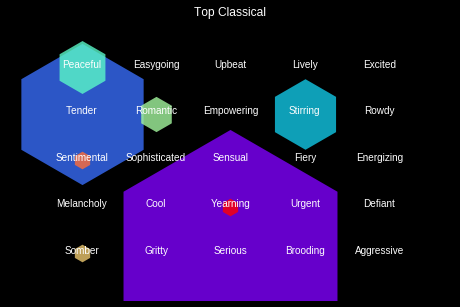

In [67]:
playlist_id = raw_input("Enter Playlist ID: ")
mood_maker(playlist_id)

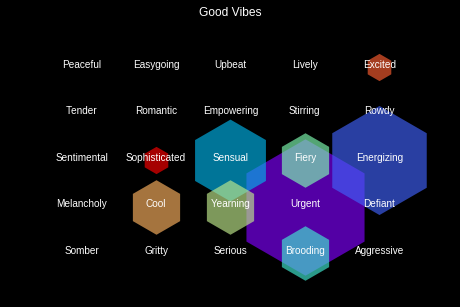

In [148]:
mood_maker('3xgbBiNc7mh3erYsCl8Fwg')

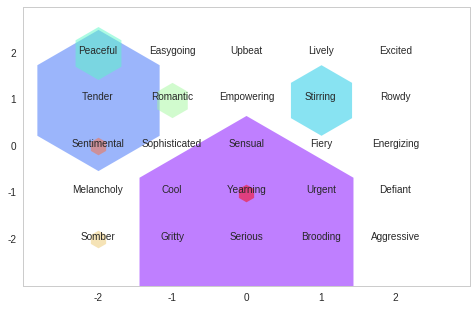

In [114]:
# Testing ground
songs = get_songs(['6CRNGyV2hoQDyYpUPjHrkz']) #'6CRNGyV2hoQDyYpUPjHrkz', '6uTuhSs7qiEPfCI3QDHXsL' top classical playlist
songs_df = master_df[master_df['id'].isin(songs)]

n = songs_df['mood_predict_map'].value_counts()
nplus = pd.DataFrame(n).reset_index()
nplus['mood'] = nplus['index'].apply(find_mood)
nplus.columns = ['coord', 'value', 'mood']

plus = len(songs_df)


fig = plt.figure(dpi = 300, figsize=(8,5))
axes = fig.add_subplot(1, 1, 1)
colors = iter(cm.rainbow(np.linspace(0, 1, len(n))))

for index, items in nplus.iterrows():
    axes.plot(items[0][0], items[0][1], marker='h', markersize = items[1]/plus*600, alpha=0.5, label=items[2],
              color = next(colors))

axes.set_xlim(-3, 3)
axes.set_ylim(-3, 3)
axes.set_xticklabels(['', -2, -1, 0, 1, 2, '']) 
axes.set_yticklabels(['', -2, -1, 0, 1, 2, ''])
for k, v in reverse_mood_map.iteritems():
    plt.annotate(v, k, ha='center', size=10)
plt.savefig('test_image.png');

## Visualization for presentation

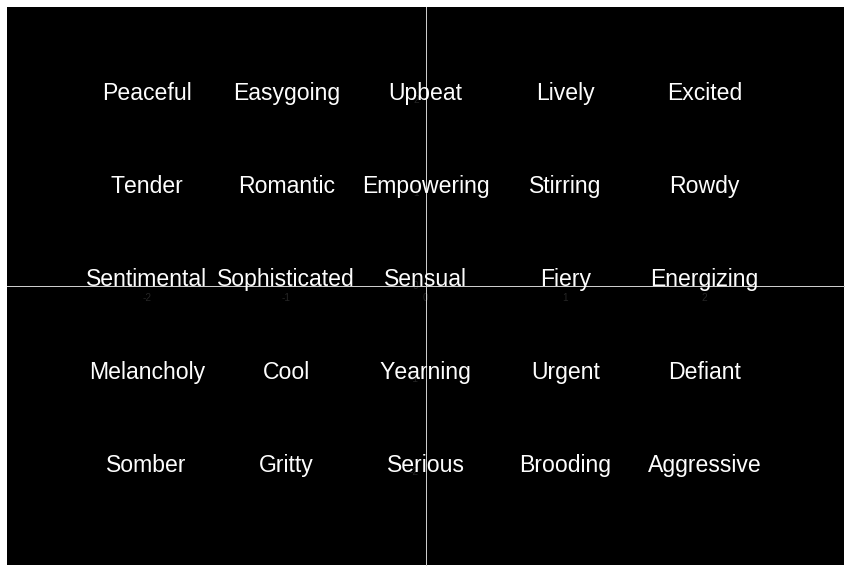

In [25]:
fig = plt.figure(dpi = 300, figsize=(15,10))
axes = fig.add_subplot(1, 1, 1)
# colors = iter(cm.rainbow(np.linspace(0, 1, len(n))))

# for index, items in nplus.iterrows():
#     axes.plot(items[0][0], items[0][1], marker='h', markersize = items[1]/plus*600, alpha=0.5, label=items[2],
#               color = next(colors))

axes.set_xlim(-3, 3)
axes.set_ylim(-3, 3)
axes.set_xticklabels(['', -2, -1, 0, 1, 2, '']) 
axes.set_yticklabels(['', -2, -1, 0, 1, 2, ''], )

axes.spines['left'].set_position('center')
axes.spines['bottom'].set_position('center')

# Eliminate upper and right axes
axes.spines['right'].set_color('none')
axes.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
axes.xaxis.set_ticks_position('bottom')
axes.yaxis.set_ticks_position('left')
axes.set_axis_bgcolor('black')
for k, v in reverse_mood_map.iteritems():
    plt.annotate(v, k, ha='center', size=23, color='white')
plt.savefig('mood_taxonomy.png', bbox_inches='tight', pad_inches=0)

In [47]:
spotify.user_playlist('spotify', '6CRNGyV2hoQDyYpUPjHrkz')['name']

u'Top Classical'